In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
data = torch.load('../data/dev.pt')

In [6]:
# idx = torch.from_numpy(np.random.permutation(range(data['data'].shape[0]))[:10000])

In [3]:
def extract_embeddings_from_tensor(x, model):
    with torch.no_grad():
        model.eval()
        size = x.shape[0]
        batch_size = 256
        embedded_x_list = list()
        for i in tqdm(range(size // batch_size + 1)):
            batch_x = x[batch_size * i: batch_size * (i + 1)].float().to('cuda:1')
            embedded_x = model.get_embedding(batch_x).to('cpu')
            embedded_x_list.append(embedded_x)
    return torch.cat(embedded_x_list, dim=0)


In [4]:
model = torch.load('siamese.buffer.pt', 'cuda:1')

In [10]:
x = data['data']

In [11]:
embedded_x = extract_embeddings_from_tensor(x, model)

In [12]:
embedded_x

tensor([[-0.1356, -0.0864,  0.5337,  ...,  0.4259, -0.1364, -0.1198],
        [-0.1350, -0.0863,  0.5356,  ...,  0.4258, -0.1355, -0.1211],
        [-0.1940, -0.0657, -0.0783,  ...,  0.0842,  0.0406,  0.1504],
        ...,
        [-0.1961, -0.0657, -0.0780,  ...,  0.0821,  0.0457,  0.1520],
        [-0.1443, -0.1496,  0.1657,  ...,  0.2479, -0.2565,  0.0571],
        [-0.1434, -0.1490,  0.1679,  ...,  0.2503, -0.2587,  0.0555]])

In [13]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def calculate_distance(x, close_fn, far_fn):
    device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
    batch_size = 2048
    x_device = x.to(device)
    
    num_iter = x.shape[0] // batch_size + 1
    anchor_idx_list, close_idx_list, far_idx_list = list(), list(), list()
    close_distance_list, far_distance_list = list(), list()
    for i in tqdm(torch.arange(num_iter), desc='create triplets'):
        batch_x = x[i * batch_size: (i + 1) * batch_size, :].to(device)

        dist = torch.cdist(x1=batch_x, x2=x_device, p=2)  # (n, n)
        sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
        sorted_dist, indices = sorted_dist, indices
        anchor_idx = torch.arange(i * batch_size, i * batch_size + batch_x.shape[0])  # (n,)
        # assert torch.equal(anchor_idx, indices[:, 0].cpu())
        # the 0-th column is the distance to oneself
        close_distance, close_idx = close_fn(sorted_dist, indices)  # (n,)
        far_distance, far_idx = far_fn(sorted_dist, indices)  # (n, r)
        anchor_idx_list.append(anchor_idx.cpu())
        close_idx_list.append(close_idx.cpu())
        far_idx_list.append(far_idx.cpu())
        close_distance_list.append(close_distance.cpu())
        far_distance_list.append(far_distance.cpu())
    anchor_idx_list = torch.cat(anchor_idx_list, dim=0)
    close_idx_list = torch.cat(close_idx_list, dim=0)
    far_idx_list = torch.cat(far_idx_list, dim=0)
    close_distance_list = torch.cat(close_distance_list, dim=0)
    far_distance_list = torch.cat(far_distance_list, dim=0)
    return anchor_idx_list, close_idx_list, far_idx_list, close_distance_list, far_distance_list


def plot_embeddings(embeddings, targets, ncluster, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    inds = np.where(targets==ncluster)[0]
    plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[ncluster])  # np.random.rand(3,)
    for i in range(ncluster):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])  # np.random.rand(3,)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)


def get_labels(data, label_anchors):
    if label_anchors.shape[0] == 1:
        x1 = data[label_anchors].unsqueeze(dim=0)
    else:
        x1 = data[label_anchors]
    dist = torch.cdist(x1=x1, x2=data, p=2)  # (n, n)
    sorted_dist, indices = torch.sort(dist, dim=1, descending=False)
    
    num_anchors = label_anchors.shape[0]
    n = data.shape[0]
    labels = - torch.ones(n)
    for i in range(num_anchors):
        labels[indices[i, :100]] = i
    labels[labels==-1.] = num_anchors
    return labels
    
    

In [14]:
def far_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, -100], indices[:, -100]


def close_func(sorted_dist: torch.tensor, indices: torch.tensor):
    return sorted_dist[:, :100], indices[:, :100]


anchor_out, close_out, _, _, _ = calculate_distance(embedded_x, close_func, far_func)
anchor_in, close_in, _, _, _ = calculate_distance(x, close_func, far_func)

In [15]:
close_out_list, close_in_list = close_out[:, 1:].numpy().tolist(), close_in[:, 1:].numpy().tolist()

In [16]:
def test():
    res = list()
    for i in range(1, 100):
        c_list = list()
        for x, y in zip(close_out_list, close_in_list):
            c = 0
            for tmp in y[:i]:
                if tmp in x[:i]:
                    c += 1
            c_list.append(c)
        res.append(np.mean(c_list) / i)
    return res

In [17]:
res = test()

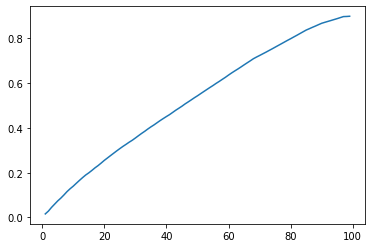

In [18]:
plt.plot(range(1, 100), res)

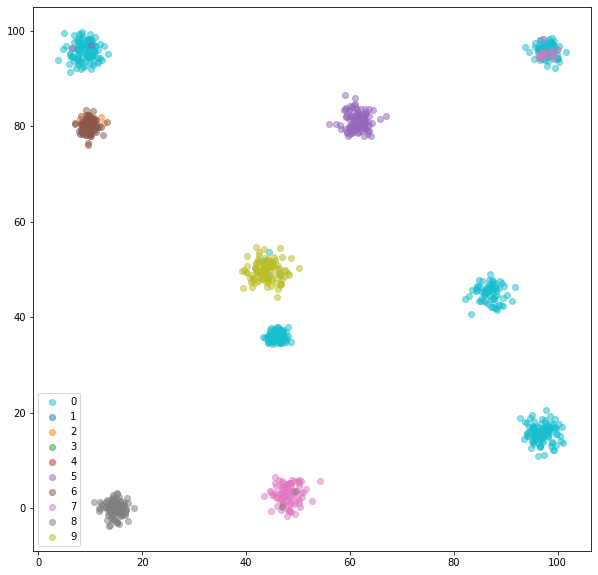

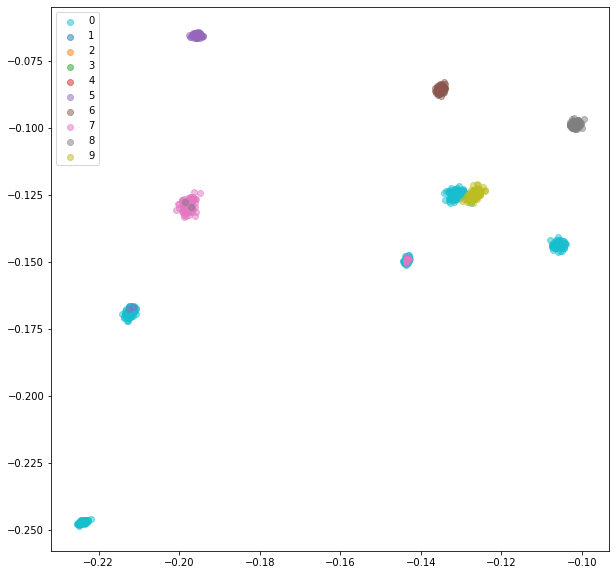

In [19]:
labels = get_labels(x, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]))
plot_embeddings(x, labels, ncluster=9)
plot_embeddings(embedded_x, labels, ncluster=9)

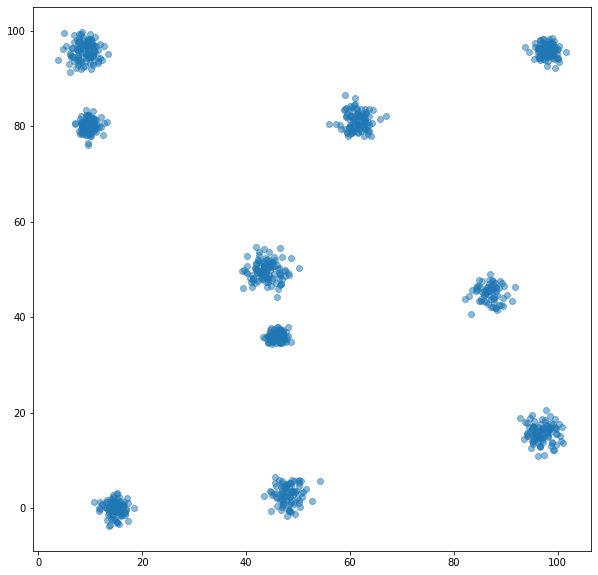

In [20]:
plt.figure(figsize=(10,10)) 
plt.scatter(x[:,0], x[:,1], alpha=0.5)  

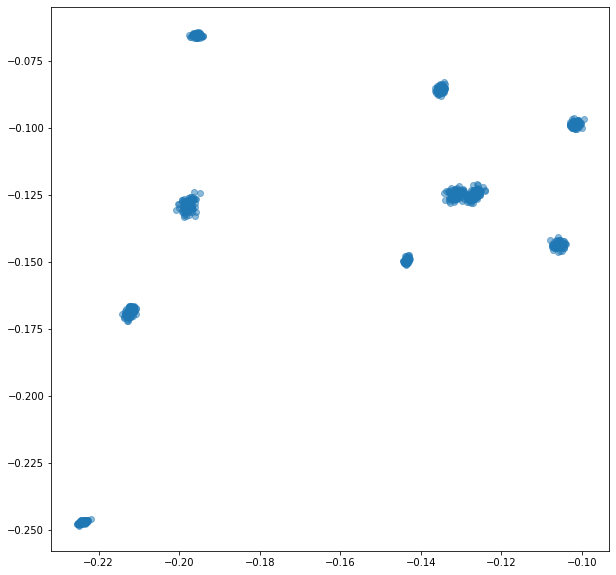

In [21]:
plt.figure(figsize=(10,10)) 
plt.scatter(embedded_x[:,0], embedded_x[:,1], alpha=0.5) 